# TODO:

*  Wrapper for reward clipping to [-1, 1] (same reason like image normalization)
* action repeat Wrapper (4 Times)
* better reward handling for different games
* Explanations
* Adding results to a Dataframe and save to hard drive (to compare with other models)

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [2]:
# Hier kann das Spiel übergeben werden
game = "MsPacman-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [3]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

In [4]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [5]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [6]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

### Episodic Life Wrapper

In [7]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Clip Reward Wrapper

In [8]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

### Resize & Grayscale Wrapper

In [9]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

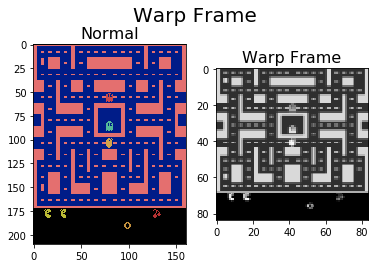

In [10]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

### Frame Stack Wrapper

In [11]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

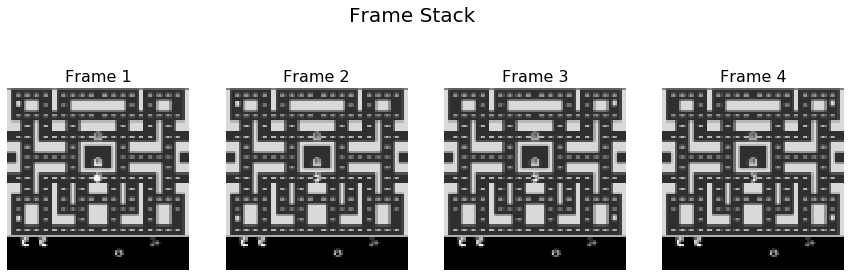

In [12]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
    axs[i].axis("off")
plt.show()

### Erstellen des Environments

In [13]:
def make_env(env_name):
    env = gym.make(env_name)
    #env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    env = NoopResetEnv(env)
    #env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)

# **Deep Q-Network und Target Network**

 *\"The input to
the neural network consists of an 84x84x4 image produced by the preprocessing
map **--w-- (falsche Darstellung)**. The first hidden layer convolves 32 filters of 8x8 with stride 4 with the
input image and applies a rectifier nonlinearity. The second hidden layer convolves
64 filters of 4x4 with stride 2, again followed by a rectifier nonlinearity.
This is followed by a third convolutional layer that convolves 64 filters of 333 with
stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists
of 512 rectifier units. The output layer is a fully-connected linear layer with a
single output for each valid action. The number of valid actions varied between 4
and 18 on the games we considered."*


[Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).](https://www.nature.com/articles/nature14236)

In [14]:
import tensorflow as tf
"""
# Tell TF to not use all GPU RAM
config = tf.compat.v1.ConfigProto
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = .2
session = tf.Session(config=config)
"""
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop, Adam

# DQN und Tagret Net Parameters
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
OUTPUT_SHAPE = env.action_space.n # Anzahl der möglichen Aktionen
LOSS_FUNCTION = "mean_squared_error"#Huber()################################################################### MSE probieren
OPTIMIZER = Adam(lr=0.00005)#RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01) # Adam probieren mit 0.00005#############################

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
    net_input = Input(shape=INPUT_SHAPE)
    x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation("relu")(x)
    net_output = Dense(OUTPUT_SHAPE)(x)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

    return model

# Deep Q-Network
DQN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)
# Target Network
TARGET = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

In [15]:
DQN.summary()
TARGET.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 21, 21, 32)        8224      
_________________________________________________________________
activation (Activation)      (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0     

# **Memory Buffer**

In [16]:
MEMORY_SIZE = 25000#1000000
MEMORY_BUFFER = deque(maxlen=MEMORY_SIZE)
TRAIN_START = 32#50000

# Speichert Transition von einem State in einen Folgestate
def save_transition(state, action, reward, next_state, done):
    MEMORY_BUFFER.append([state, action, reward, next_state, done])

# **Experience Replay**

In [17]:
import random
MINIBATCH_SIZE = 32
GAMMA = 0.99

def replay():

    # Ziehe 32 (MINIBATCH_SIZE) zufällige Transitionen aus dem Buffer in einen Minibatch
    minibatch = random.sample(MEMORY_BUFFER, MINIBATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.concatenate(states)
    next_states = np.concatenate(next_states)

    q_values = DQN.predict(states)
    q_values_next = TARGET.predict(next_states)

    # Q-Values Update
    for i in range(MINIBATCH_SIZE):
        a = actions[i]
        done = dones[i]
        if done:
            q_values[i][a] = rewards[i]
        else:
            q_values[i][a] = rewards[i] + GAMMA * np.max(q_values_next[i])

    DQN.fit(states, q_values, batch_size=MINIBATCH_SIZE, verbose=0)

# **Aktion wählen**
Exploration & Exploitation

In [18]:
def linear(epsilon, decay, epsilon_min, decay_step):
    return epsilon - decay

def exponential(epsilon, decay, epsilon_min, decay_step):
    epsilon = 1
    return epsilon_min + (epsilon - epsilon_min) * np.exp(-decay * decay_step)

def epsilon_decay(mode, epsilon, decay, epsilon_min, decay_step):
    decay_strategy = {
        "linear": linear,
        "exponential": exponential
    }
    strategy = decay_strategy.get(mode)
    return strategy(epsilon, decay, epsilon_min, decay_step)

In [19]:
EPSILON = 1.0
EPSILON_MIN = 0.02 #0.1
#EPSILON_STEPS = 1000000
EPSILON_DECAY = 0.00002 #0.0000009

def get_action(state):
    if np.random.rand() <= EPSILON:
        return np.random.randint(env.action_space.n)
    else:
        return np.argmax(DQN(state))

In [20]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

300.0

# **Training des Agenten**

In [ ]:
from datetime import datetime
start_time = datetime.now()

EPISODES = 15000
REWARD_LIST = []
MEAN_LIST = []
BEST_MEAN_REWARD = INITIAL_MEAN_REWARD
EPSILON_LIST = []
STEPS = 0
SYNC = 1000 #10000

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False
    
    while not done:
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)
        
        # Transition im MEMORY BUFFER speichern
        save_transition(state, action, reward, next_state, done)
        
        # Experience Replay, falls genügend Transitionen gespeichert
        if len(MEMORY_BUFFER) > TRAIN_START:
            replay()
            
        # Synchronisation zwischen Target Networks und Deep Q-Network (alle 1000 Updates - Algorithm 1)
        if STEPS % SYNC == 0:
            TARGET.set_weights(DQN.get_weights())

        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward
        
        # State aktualisieren
        state = next_state
        STEPS += 1
        
        # EPSILON verringern
        if EPSILON > EPSILON_MIN:
            EPSILON = epsilon_decay("exponential", EPSILON, EPSILON_DECAY, EPSILON_MIN, STEPS)

        if done:
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            EPSILON_LIST.append(EPSILON)
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2),"\tBestMean:", BEST_MEAN_REWARD, "\tTRAIN START:", (len(MEMORY_BUFFER)>TRAIN_START), "\tEpsi:", EPSILON)

            # Übernahme des höchsteb Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward
        
                # Trainierte Gewichte speichern
                if EPSILON < 0.3:
                    import os
                    PATH = "WEIGHTS"
                    try:
                        os.makedirs(PATH)
                    except FileExistsError:
                        # Pfad existiert bereits
                        pass
                    DQN.save_weights(PATH +"/" + game + "_DQN"+ "_Ep_"+ str(episode+1)+ ".h5")
                    #TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_Ep_"+ str(episode+1)+ ".h5")
                    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

W0319 09:31:38.178814 140079346210624 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Episode: 1 	Reward: 500.0 	Mean: 500.0 	BestMean: 300.0 	TRAIN START: True 	Epsi: 0.9966345918208087
Episode: 2 	Reward: 340.0 	Mean: 420.0 	BestMean: 500.0 	TRAIN START: True 	Epsi: 0.9939817552243894
Episode: 3 	Reward: 240.0 	Mean: 360.0 	BestMean: 500.0 	TRAIN START: True 	Epsi: 0.991277846119928
Episode: 4 	Reward: 390.0 	Mean: 367.5 	BestMean: 500.0 	TRAIN START: True 	Epsi: 0.9878649583080544
Episode: 5 	Reward: 160.0 	Mean: 326.0 	BestMean: 500.0 	TRAIN START: True 	Epsi: 0.9859891204399941
Episode: 6 	Reward: 450.0 	Mean: 346.67 	BestMean: 500.0 	TRAIN START: True 	Epsi: 0.9827680988781013
Episode: 7 	Reward: 660.0 	Mean: 391.43 	BestMean: 500.0 	TRAIN START: True 	Epsi: 0.979557817581997
Episode: 8 	Reward: 300.0 	Mean: 380.0 	BestMean: 500.0 	TRAIN START: True 	Epsi: 0.977238495175467
Episode: 9 	Reward: 340.0 	Mean: 375.56 	BestMean: 500.0 	TRAIN START: True 	Epsi: 0.9743710829588244
Episode: 10 	Reward: 320.0 	Mean: 370.0 	BestMean: 500.0 	TRAIN START: True 	Epsi: 0.971835

Episode: 82 	Reward: 780.0 	Mean: 527.0 	BestMean: 557.0 	TRAIN START: True 	Epsi: 0.7691000642059482
Episode: 83 	Reward: 850.0 	Mean: 575.0 	BestMean: 557.0 	TRAIN START: True 	Epsi: 0.7654533610852388
Episode: 84 	Reward: 530.0 	Mean: 587.0 	BestMean: 575.0 	TRAIN START: True 	Epsi: 0.7625517547870729
Episode: 85 	Reward: 750.0 	Mean: 617.0 	BestMean: 587.0 	TRAIN START: True 	Epsi: 0.7597797980144185
Episode: 86 	Reward: 800.0 	Mean: 639.0 	BestMean: 617.0 	TRAIN START: True 	Epsi: 0.7576080394576521
Episode: 87 	Reward: 270.0 	Mean: 555.0 	BestMean: 639.0 	TRAIN START: True 	Epsi: 0.7554426564943278
Episode: 88 	Reward: 480.0 	Mean: 566.0 	BestMean: 639.0 	TRAIN START: True 	Epsi: 0.7529610565817945
Episode: 89 	Reward: 1260.0 	Mean: 657.0 	BestMean: 639.0 	TRAIN START: True 	Epsi: 0.7496555486816346
Episode: 90 	Reward: 530.0 	Mean: 655.0 	BestMean: 657.0 	TRAIN START: True 	Epsi: 0.7466991526988352
Episode: 91 	Reward: 320.0 	Mean: 657.0 	BestMean: 657.0 	TRAIN START: True 	Epsi

Episode: 162 	Reward: 1100.0 	Mean: 586.0 	BestMean: 769.0 	TRAIN START: True 	Epsi: 0.5868601201773309
Episode: 163 	Reward: 610.0 	Mean: 523.0 	BestMean: 769.0 	TRAIN START: True 	Epsi: 0.5846649642674038
Episode: 164 	Reward: 410.0 	Mean: 512.0 	BestMean: 769.0 	TRAIN START: True 	Epsi: 0.5829397304307155
Episode: 165 	Reward: 340.0 	Mean: 504.0 	BestMean: 769.0 	TRAIN START: True 	Epsi: 0.5815229082557527
Episode: 166 	Reward: 590.0 	Mean: 522.0 	BestMean: 769.0 	TRAIN START: True 	Epsi: 0.5792365621078295
Episode: 167 	Reward: 350.0 	Mean: 522.0 	BestMean: 769.0 	TRAIN START: True 	Epsi: 0.5775502153555393
Episode: 168 	Reward: 440.0 	Mean: 537.0 	BestMean: 769.0 	TRAIN START: True 	Epsi: 0.5759356619649573
Episode: 169 	Reward: 410.0 	Mean: 545.0 	BestMean: 769.0 	TRAIN START: True 	Epsi: 0.5743368706231149
Episode: 170 	Reward: 320.0 	Mean: 545.0 	BestMean: 769.0 	TRAIN START: True 	Epsi: 0.5728421798130506
Episode: 171 	Reward: 420.0 	Mean: 499.0 	BestMean: 769.0 	TRAIN START: 

Episode: 242 	Reward: 340.0 	Mean: 501.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.4504247757495294
Episode: 243 	Reward: 1660.0 	Mean: 633.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.4478157326412607
Episode: 244 	Reward: 390.0 	Mean: 637.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.44679020600713537
Episode: 245 	Reward: 400.0 	Mean: 629.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.4453245700376505
Episode: 246 	Reward: 470.0 	Mean: 644.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.4439148339219669
Episode: 247 	Reward: 610.0 	Mean: 663.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.4420452651467444
Episode: 248 	Reward: 400.0 	Mean: 651.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.44106725506197236
Episode: 249 	Reward: 560.0 	Mean: 624.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.4393611876667435
Episode: 250 	Reward: 620.0 	Mean: 621.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.43783748775983455
Episode: 251 	Reward: 1120.0 	Mean: 657.0 	BestMean: 1039.0 

Episode: 321 	Reward: 450.0 	Mean: 510.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.34558142099188427
Episode: 322 	Reward: 1800.0 	Mean: 654.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.34356906094413847
Episode: 323 	Reward: 1290.0 	Mean: 756.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.3418136243692247
Episode: 324 	Reward: 710.0 	Mean: 749.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.3407726355388304
Episode: 325 	Reward: 410.0 	Mean: 743.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.3398437424417578
Episode: 326 	Reward: 250.0 	Mean: 746.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.33925577105522686
Episode: 327 	Reward: 580.0 	Mean: 768.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.33819759943218347
Episode: 328 	Reward: 1510.0 	Mean: 794.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.33645231656276237
Episode: 329 	Reward: 880.0 	Mean: 838.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.3346914300786028
Episode: 330 	Reward: 390.0 	Mean: 827.0 	BestMean: 1039

Episode: 400 	Reward: 1180.0 	Mean: 827.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.2617568748225713
Episode: 401 	Reward: 410.0 	Mean: 814.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.26105197440355626
Episode: 402 	Reward: 620.0 	Mean: 738.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.260084890607256
Episode: 403 	Reward: 1780.0 	Mean: 870.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.2586343756694457
Episode: 404 	Reward: 250.0 	Mean: 869.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.2581623470681472
Episode: 405 	Reward: 420.0 	Mean: 826.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.2575534312045074
Episode: 406 	Reward: 720.0 	Mean: 879.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.2561796092385014
Episode: 407 	Reward: 2150.0 	Mean: 959.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.2551615139956569
Episode: 408 	Reward: 810.0 	Mean: 975.0 	BestMean: 1039.0 	TRAIN START: True 	Epsi: 0.25431645456491186
Episode: 409 	Reward: 470.0 	Mean: 881.0 	BestMean: 1039.0 	

Episode: 479 	Reward: 1020.0 	Mean: 767.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.19472487110566397
Episode: 480 	Reward: 680.0 	Mean: 778.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.19418406269137592
Episode: 481 	Reward: 730.0 	Mean: 765.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.19349565774452018
Episode: 482 	Reward: 1080.0 	Mean: 835.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.19282379884161224
Episode: 483 	Reward: 580.0 	Mean: 764.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.19215454170056562
Episode: 484 	Reward: 740.0 	Mean: 703.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.19150845602601452
Episode: 485 	Reward: 880.0 	Mean: 724.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.19070767174861283
Episode: 486 	Reward: 750.0 	Mean: 770.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.18992082132917348
Episode: 487 	Reward: 480.0 	Mean: 747.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.18938810674978546
Episode: 488 	Reward: 750.0 	Mean: 769.0 	BestMean: 1

Episode: 557 	Reward: 790.0 	Mean: 869.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.14467278332718436
Episode: 558 	Reward: 1480.0 	Mean: 928.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.14408323267307901
Episode: 559 	Reward: 310.0 	Mean: 893.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.1438204548627101
Episode: 560 	Reward: 830.0 	Mean: 961.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.14327191071228168
Episode: 561 	Reward: 2640.0 	Mean: 1128.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.14246344431122596
Episode: 562 	Reward: 700.0 	Mean: 1098.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.14185752953828473
Episode: 563 	Reward: 1430.0 	Mean: 1121.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.14101718637464072
Episode: 564 	Reward: 450.0 	Mean: 1063.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.14048588048472338
Episode: 565 	Reward: 1160.0 	Mean: 1065.0 	BestMean: 1180.0 	TRAIN START: True 	Epsi: 0.14003130354816584
Episode: 566 	Reward: 1550.0 	Mean: 1134.0 	Bes

Episode: 635 	Reward: 1500.0 	Mean: 1147.0 	BestMean: 1282.0 	TRAIN START: True 	Epsi: 0.10876678805630614
Episode: 636 	Reward: 620.0 	Mean: 1145.0 	BestMean: 1282.0 	TRAIN START: True 	Epsi: 0.10835233007634416
Episode: 637 	Reward: 1020.0 	Mean: 1115.0 	BestMean: 1282.0 	TRAIN START: True 	Epsi: 0.10796971184594295
Episode: 638 	Reward: 3780.0 	Mean: 1356.0 	BestMean: 1282.0 	TRAIN START: True 	Epsi: 0.10751870760091008
Episode: 639 	Reward: 720.0 	Mean: 1314.0 	BestMean: 1356.0 	TRAIN START: True 	Epsi: 0.10718851135025698
Episode: 640 	Reward: 990.0 	Mean: 1350.0 	BestMean: 1356.0 	TRAIN START: True 	Epsi: 0.10689083595650653
Episode: 641 	Reward: 930.0 	Mean: 1352.0 	BestMean: 1356.0 	TRAIN START: True 	Epsi: 0.1065526216428743
Episode: 642 	Reward: 660.0 	Mean: 1276.0 	BestMean: 1356.0 	TRAIN START: True 	Epsi: 0.1062381427988169
Episode: 643 	Reward: 990.0 	Mean: 1232.0 	BestMean: 1356.0 	TRAIN START: True 	Epsi: 0.10578400538266931
Episode: 644 	Reward: 560.0 	Mean: 1177.0 	Be

Episode: 713 	Reward: 960.0 	Mean: 1300.0 	BestMean: 1645.0 	TRAIN START: True 	Epsi: 0.08309191123210363
Episode: 714 	Reward: 930.0 	Mean: 1238.0 	BestMean: 1645.0 	TRAIN START: True 	Epsi: 0.08278979571549096
Episode: 715 	Reward: 1630.0 	Mean: 1254.0 	BestMean: 1645.0 	TRAIN START: True 	Epsi: 0.082421675052063
Episode: 716 	Reward: 1360.0 	Mean: 1282.0 	BestMean: 1645.0 	TRAIN START: True 	Epsi: 0.08199616768885587
Episode: 717 	Reward: 1270.0 	Mean: 1131.0 	BestMean: 1645.0 	TRAIN START: True 	Epsi: 0.08168942804030448
Episode: 718 	Reward: 2270.0 	Mean: 1237.0 	BestMean: 1645.0 	TRAIN START: True 	Epsi: 0.08146036968069345
Episode: 719 	Reward: 1140.0 	Mean: 1247.0 	BestMean: 1645.0 	TRAIN START: True 	Epsi: 0.08115383480808556
Episode: 720 	Reward: 500.0 	Mean: 1208.0 	BestMean: 1645.0 	TRAIN START: True 	Epsi: 0.08096333218211656
Episode: 721 	Reward: 1160.0 	Mean: 1251.0 	BestMean: 1645.0 	TRAIN START: True 	Epsi: 0.080581682091602
Episode: 722 	Reward: 1820.0 	Mean: 1304.0 	

Episode: 791 	Reward: 1300.0 	Mean: 1277.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.06331298920508428
Episode: 792 	Reward: 1040.0 	Mean: 1077.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.0630831759477996
Episode: 793 	Reward: 1430.0 	Mean: 1094.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.06287429969312312
Episode: 794 	Reward: 1180.0 	Mean: 1111.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.06274330486037152
Episode: 795 	Reward: 880.0 	Mean: 1086.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.062491861847975755
Episode: 796 	Reward: 980.0 	Mean: 1084.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.06232815941020582
Episode: 797 	Reward: 720.0 	Mean: 1026.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.06217436498561492
Episode: 798 	Reward: 1900.0 	Mean: 1119.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.06190614905562014
Episode: 799 	Reward: 710.0 	Mean: 1110.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.061735520286857665
Episode: 800 	Reward: 730.0 	Mean: 1087.

Episode: 868 	Reward: 1160.0 	Mean: 1302.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.050142392561931
Episode: 869 	Reward: 1710.0 	Mean: 1334.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.05002026253983624
Episode: 870 	Reward: 330.0 	Mean: 1234.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.049934527248878396
Episode: 871 	Reward: 930.0 	Mean: 1254.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.0498025086145509
Episode: 872 	Reward: 2040.0 	Mean: 1310.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.04962363645808181
Episode: 873 	Reward: 900.0 	Mean: 1282.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.04947942527364818
Episode: 874 	Reward: 1360.0 	Mean: 1174.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.04933356934601539
Episode: 875 	Reward: 1370.0 	Mean: 1274.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.04915751172369513
Episode: 876 	Reward: 830.0 	Mean: 1288.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.049023695183771046
Episode: 877 	Reward: 1250.0 	Mean: 1188.0

Episode: 945 	Reward: 1080.0 	Mean: 1257.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.040839965713631965
Episode: 946 	Reward: 610.0 	Mean: 1237.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.040779617360468645
Episode: 947 	Reward: 860.0 	Mean: 1110.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.04068838789608771
Episode: 948 	Reward: 2580.0 	Mean: 1250.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.04059220429035031
Episode: 949 	Reward: 1320.0 	Mean: 1279.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.04043793170601798
Episode: 950 	Reward: 1200.0 	Mean: 1298.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.04036408014521559
Episode: 951 	Reward: 970.0 	Mean: 1322.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.04026899891375979
Episode: 952 	Reward: 1450.0 	Mean: 1354.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.0401396915456585
Episode: 953 	Reward: 1450.0 	Mean: 1330.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.040042851803671516
Episode: 954 	Reward: 490.0 	Mean: 120

Episode: 1022 	Reward: 890.0 	Mean: 1272.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.03439631932766457
Episode: 1023 	Reward: 2150.0 	Mean: 1356.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.03433168143502492
Episode: 1024 	Reward: 1260.0 	Mean: 1348.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.03427760993871148
Episode: 1025 	Reward: 620.0 	Mean: 1304.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.03423142534195907
Episode: 1026 	Reward: 1100.0 	Mean: 1261.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.034157330856527286
Episode: 1027 	Reward: 510.0 	Mean: 1174.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.03411972239787414
Episode: 1028 	Reward: 1040.0 	Mean: 1169.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.034055201933938156
Episode: 1029 	Reward: 670.0 	Mean: 1108.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.034001613481659705
Episode: 1030 	Reward: 1480.0 	Mean: 1136.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.03393373072884176
Episode: 1031 	Reward: 1070.0

Episode: 1098 	Reward: 2000.0 	Mean: 1697.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.02989225939147875
Episode: 1099 	Reward: 3170.0 	Mean: 1751.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.029837411048950928
Episode: 1100 	Reward: 1140.0 	Mean: 1722.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.0297912837012008
Episode: 1101 	Reward: 1040.0 	Mean: 1561.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.02975005154502115
Episode: 1102 	Reward: 1800.0 	Mean: 1646.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.029705498413496477
Episode: 1103 	Reward: 860.0 	Mean: 1538.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.029672362303967373
Episode: 1104 	Reward: 1850.0 	Mean: 1606.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.02961796372875477
Episode: 1105 	Reward: 1930.0 	Mean: 1606.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.02956272350225754
Episode: 1106 	Reward: 1240.0 	Mean: 1636.0 	BestMean: 1978.0 	TRAIN START: True 	Epsi: 0.029523406130829096
Episode: 1107 	Reward: 640

Episode: 1174 	Reward: 690.0 	Mean: 1676.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.02688684156709023
Episode: 1175 	Reward: 2430.0 	Mean: 1686.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.026847561282040664
Episode: 1176 	Reward: 1280.0 	Mean: 1724.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.026820362150314032
Episode: 1177 	Reward: 2300.0 	Mean: 1688.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.02678783861241698
Episode: 1178 	Reward: 900.0 	Mean: 1716.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.02675749711114336
Episode: 1179 	Reward: 1740.0 	Mean: 1543.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.026721373823522385
Episode: 1180 	Reward: 580.0 	Mean: 1483.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.02669628283481817
Episode: 1181 	Reward: 1050.0 	Mean: 1509.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.026669551202385934
Episode: 1182 	Reward: 1560.0 	Mean: 1397.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.026631775536009972
Episode: 1183 	Reward: 162

Episode: 1250 	Reward: 1510.0 	Mean: 1570.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.02472360638120826
Episode: 1251 	Reward: 2630.0 	Mean: 1659.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.024693190233917542
Episode: 1252 	Reward: 1530.0 	Mean: 1658.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.024672211768519255
Episode: 1253 	Reward: 2020.0 	Mean: 1736.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.02464305507850307
Episode: 1254 	Reward: 880.0 	Mean: 1739.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.024621561207282903
Episode: 1255 	Reward: 930.0 	Mean: 1688.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.02460550612632521
Episode: 1256 	Reward: 1100.0 	Mean: 1635.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.02458455282821672
Episode: 1257 	Reward: 710.0 	Mean: 1517.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.02457081977960477
Episode: 1258 	Reward: 1260.0 	Mean: 1395.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.024549478321001766
Episode: 1259 	Reward: 1450

Episode: 1326 	Reward: 2820.0 	Mean: 1973.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.02316924240910997
Episode: 1327 	Reward: 1800.0 	Mean: 1950.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.023146254103333208
Episode: 1328 	Reward: 2430.0 	Mean: 2016.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.02313206512603204
Episode: 1329 	Reward: 2080.0 	Mean: 2072.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.02311644388604608
Episode: 1330 	Reward: 1660.0 	Mean: 2115.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.023102451395275427
Episode: 1331 	Reward: 2100.0 	Mean: 2120.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.0230837073915137
Episode: 1332 	Reward: 1190.0 	Mean: 2188.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.023070353101205827
Episode: 1333 	Reward: 840.0 	Mean: 1983.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.023058463212473547
Episode: 1334 	Reward: 1450.0 	Mean: 1931.0 	BestMean: 2221.0 	TRAIN START: True 	Epsi: 0.02304217454835886
Episode: 1335 	Reward: 436

Episode: 1402 	Reward: 2480.0 	Mean: 1798.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.022122283372704502
Episode: 1403 	Reward: 1830.0 	Mean: 1794.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.022109967557262133
Episode: 1404 	Reward: 2700.0 	Mean: 1875.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02209936007408505
Episode: 1405 	Reward: 1770.0 	Mean: 1931.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.022089181937031653
Episode: 1406 	Reward: 1720.0 	Mean: 1980.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.022079011565069962
Episode: 1407 	Reward: 1320.0 	Mean: 1932.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02206793923275095
Episode: 1408 	Reward: 1010.0 	Mean: 1897.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.022057872272655966
Episode: 1409 	Reward: 4090.0 	Mean: 2116.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02204421238124948
Episode: 1410 	Reward: 1220.0 	Mean: 2090.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.022031618105130345
Episode: 1411 	Reward:

Episode: 1478 	Reward: 1260.0 	Mean: 2286.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.021409355590158736
Episode: 1479 	Reward: 1500.0 	Mean: 2132.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.021403055799183217
Episode: 1480 	Reward: 1670.0 	Mean: 2073.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.021395723015467213
Episode: 1481 	Reward: 2330.0 	Mean: 2113.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.021388234188651423
Episode: 1482 	Reward: 2730.0 	Mean: 2121.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02137868834378762
Episode: 1483 	Reward: 3490.0 	Mean: 2321.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02136983811916445
Episode: 1484 	Reward: 1280.0 	Mean: 2275.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.021364478864738704
Episode: 1485 	Reward: 1800.0 	Mean: 2333.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.021356642058147978
Episode: 1486 	Reward: 2650.0 	Mean: 2166.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.021350523873558732
Episode: 1487 	Reward

Episode: 1554 	Reward: 2090.0 	Mean: 2367.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020942567797711784
Episode: 1555 	Reward: 1240.0 	Mean: 2197.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020937322916228778
Episode: 1556 	Reward: 4090.0 	Mean: 2345.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020933282414997114
Episode: 1557 	Reward: 1210.0 	Mean: 2284.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020928274838064816
Episode: 1558 	Reward: 3040.0 	Mean: 2432.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020923146414312352
Episode: 1559 	Reward: 2310.0 	Mean: 2417.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020917972882704635
Episode: 1560 	Reward: 2220.0 	Mean: 2411.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020913321405216467
Episode: 1561 	Reward: 2970.0 	Mean: 2303.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02090778525801452
Episode: 1562 	Reward: 2020.0 	Mean: 2355.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02090210222997967
Episode: 1563 	Reward

Episode: 1630 	Reward: 1840.0 	Mean: 1927.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020634227581033383
Episode: 1631 	Reward: 2690.0 	Mean: 1983.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020630799366398223
Episode: 1632 	Reward: 2360.0 	Mean: 2099.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020628268643107243
Episode: 1633 	Reward: 4170.0 	Mean: 2410.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02062499762557348
Episode: 1634 	Reward: 530.0 	Mean: 2311.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.0206229759102141
Episode: 1635 	Reward: 1450.0 	Mean: 2312.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020619720054237067
Episode: 1636 	Reward: 1330.0 	Mean: 2055.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020616826540486653
Episode: 1637 	Reward: 420.0 	Mean: 1967.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020615631056992042
Episode: 1638 	Reward: 5530.0 	Mean: 2278.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020610823380223693
Episode: 1639 	Reward: 9

Episode: 1706 	Reward: 1830.0 	Mean: 1825.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.0204270614229949
Episode: 1707 	Reward: 2200.0 	Mean: 1915.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020425288537633528
Episode: 1708 	Reward: 1710.0 	Mean: 2068.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02042315047584541
Episode: 1709 	Reward: 1070.0 	Mean: 2009.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020420476188278015
Episode: 1710 	Reward: 1770.0 	Mean: 1932.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020418228465188072
Episode: 1711 	Reward: 1700.0 	Mean: 1871.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02041596779884672
Episode: 1712 	Reward: 860.0 	Mean: 1798.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02041465541526051
Episode: 1713 	Reward: 1960.0 	Mean: 1749.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02041216668824499
Episode: 1714 	Reward: 2310.0 	Mean: 1810.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02040949629295809
Episode: 1715 	Reward: 1470

Episode: 1782 	Reward: 1970.0 	Mean: 1852.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02028322109602156
Episode: 1783 	Reward: 1190.0 	Mean: 1807.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020281972021265887
Episode: 1784 	Reward: 1160.0 	Mean: 1717.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020280767759972385
Episode: 1785 	Reward: 2650.0 	Mean: 1813.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02027937301233187
Episode: 1786 	Reward: 1480.0 	Mean: 1918.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020277774004783037
Episode: 1787 	Reward: 1710.0 	Mean: 1923.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02027600744794106
Episode: 1788 	Reward: 1940.0 	Mean: 1889.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02027445514753665
Episode: 1789 	Reward: 3000.0 	Mean: 2049.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020272873372517406
Episode: 1790 	Reward: 2600.0 	Mean: 2170.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02027098618741889
Episode: 1791 	Reward: 5

Episode: 1858 	Reward: 1300.0 	Mean: 1849.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020189928531357256
Episode: 1859 	Reward: 1080.0 	Mean: 1778.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020189019058886856
Episode: 1860 	Reward: 1980.0 	Mean: 1840.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020187850766171602
Episode: 1861 	Reward: 1570.0 	Mean: 1819.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020186768120602945
Episode: 1862 	Reward: 1420.0 	Mean: 1777.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020186044864319543
Episode: 1863 	Reward: 1420.0 	Mean: 1740.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020184857979271283
Episode: 1864 	Reward: 1790.0 	Mean: 1626.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020183777879296528
Episode: 1865 	Reward: 2510.0 	Mean: 1661.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02018300763085747
Episode: 1866 	Reward: 1870.0 	Mean: 1700.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020182127656518552
Episode: 1867 	Rewar

Episode: 1934 	Reward: 1630.0 	Mean: 1921.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020128304693174764
Episode: 1935 	Reward: 1770.0 	Mean: 1902.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020127506564640147
Episode: 1936 	Reward: 3330.0 	Mean: 2122.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020126672859119992
Episode: 1937 	Reward: 1820.0 	Mean: 2061.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020126048638290824
Episode: 1938 	Reward: 2890.0 	Mean: 2096.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020125455090592596
Episode: 1939 	Reward: 2170.0 	Mean: 1989.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020124724568065556
Episode: 1940 	Reward: 2230.0 	Mean: 1948.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02012384711367364
Episode: 1941 	Reward: 2980.0 	Mean: 2088.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020123194924208797
Episode: 1942 	Reward: 850.0 	Mean: 2083.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02012271294540155
Episode: 1943 	Reward:

Episode: 2010 	Reward: 1460.0 	Mean: 2460.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020086017249407485
Episode: 2011 	Reward: 2620.0 	Mean: 2526.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020085391609849554
Episode: 2012 	Reward: 1720.0 	Mean: 2433.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020084981012624323
Episode: 2013 	Reward: 3430.0 	Mean: 2566.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02008438484725977
Episode: 2014 	Reward: 2610.0 	Mean: 2558.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02008379621594214
Episode: 2015 	Reward: 5550.0 	Mean: 2701.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020083348269792814
Episode: 2016 	Reward: 1000.0 	Mean: 2591.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02008285630568619
Episode: 2017 	Reward: 1130.0 	Mean: 2442.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020082505738677335
Episode: 2018 	Reward: 2700.0 	Mean: 2465.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.0200820548438097
Episode: 2019 	Reward: 3

Episode: 2086 	Reward: 4880.0 	Mean: 2614.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02005676999054576
Episode: 2087 	Reward: 1950.0 	Mean: 2557.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020056424747664756
Episode: 2088 	Reward: 4120.0 	Mean: 2652.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02005611638573094
Episode: 2089 	Reward: 2100.0 	Mean: 2735.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020055788505338377
Episode: 2090 	Reward: 3020.0 	Mean: 2618.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020055484730160136
Episode: 2091 	Reward: 4200.0 	Mean: 2952.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.02005509438749615
Episode: 2092 	Reward: 2690.0 	Mean: 3057.0 	BestMean: 2962.0 	TRAIN START: True 	Epsi: 0.020054728678039684
Episode: 2093 	Reward: 1420.0 	Mean: 2863.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020054415435294466
Episode: 2094 	Reward: 1640.0 	Mean: 2868.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020054125631335223
Episode: 2095 	Reward:

Episode: 2162 	Reward: 2430.0 	Mean: 2255.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020038164579629966
Episode: 2163 	Reward: 2280.0 	Mean: 2396.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.02003795145528916
Episode: 2164 	Reward: 690.0 	Mean: 2358.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020037740275907066
Episode: 2165 	Reward: 260.0 	Mean: 2214.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020037674664925096
Episode: 2166 	Reward: 2310.0 	Mean: 2172.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020037494259852007
Episode: 2167 	Reward: 3460.0 	Mean: 2309.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.02003722452620607
Episode: 2168 	Reward: 3180.0 	Mean: 2289.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020037022574589943
Episode: 2169 	Reward: 1410.0 	Mean: 2280.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020036859295921937
Episode: 2170 	Reward: 2380.0 	Mean: 2272.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.0200366344058963
Episode: 2171 	Reward: 25

Episode: 2238 	Reward: 2240.0 	Mean: 2108.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020025970151274965
Episode: 2239 	Reward: 1450.0 	Mean: 2143.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020025822542497365
Episode: 2240 	Reward: 2710.0 	Mean: 2230.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020025683990258444
Episode: 2241 	Reward: 2400.0 	Mean: 2288.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.02002554822520527
Episode: 2242 	Reward: 1560.0 	Mean: 2200.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020025429447442945
Episode: 2243 	Reward: 2940.0 	Mean: 2203.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020025326413187394
Episode: 2244 	Reward: 1740.0 	Mean: 2223.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020025178937981128
Episode: 2245 	Reward: 2380.0 	Mean: 2185.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020025041835609828
Episode: 2246 	Reward: 4150.0 	Mean: 2453.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.02002486367369848
Episode: 2247 	Reward

Episode: 2314 	Reward: 2550.0 	Mean: 2131.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.02001770359720137
Episode: 2315 	Reward: 3340.0 	Mean: 2350.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020017601917599864
Episode: 2316 	Reward: 2360.0 	Mean: 2420.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.02001750992478331
Episode: 2317 	Reward: 3550.0 	Mean: 2475.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.02001739543561179
Episode: 2318 	Reward: 1190.0 	Mean: 2386.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020017329458392574
Episode: 2319 	Reward: 2570.0 	Mean: 2552.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020017261659887563
Episode: 2320 	Reward: 1190.0 	Mean: 2473.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020017158056853057
Episode: 2321 	Reward: 2420.0 	Mean: 2351.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.02001707282214052
Episode: 2322 	Reward: 2580.0 	Mean: 2440.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.0200169897097277
Episode: 2323 	Reward: 65

Episode: 2390 	Reward: 3950.0 	Mean: 2943.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020011840997220892
Episode: 2391 	Reward: 1040.0 	Mean: 2845.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.02001178948285593
Episode: 2392 	Reward: 4960.0 	Mean: 3237.0 	BestMean: 3057.0 	TRAIN START: True 	Epsi: 0.020011712162720956
Episode: 2393 	Reward: 3040.0 	Mean: 3055.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.020011645127482127
Episode: 2394 	Reward: 1680.0 	Mean: 2996.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.020011585193387266
Episode: 2395 	Reward: 1550.0 	Mean: 2871.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.020011497939560297
Episode: 2396 	Reward: 1250.0 	Mean: 2679.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.02001141202758621
Episode: 2397 	Reward: 1590.0 	Mean: 2576.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.020011335822573247
Episode: 2398 	Reward: 1170.0 	Mean: 2278.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.020011295086980043
Episode: 2399 	Reward

Episode: 2466 	Reward: 2580.0 	Mean: 2124.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.020007895775350275
Episode: 2467 	Reward: 3620.0 	Mean: 2253.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.02000783928672012
Episode: 2468 	Reward: 2530.0 	Mean: 2342.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.02000780408918373
Episode: 2469 	Reward: 2260.0 	Mean: 2348.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.020007754147415784
Episode: 2470 	Reward: 1450.0 	Mean: 2386.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.02000771300488769
Episode: 2471 	Reward: 2320.0 	Mean: 2460.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.020007660734375612
Episode: 2472 	Reward: 1800.0 	Mean: 2245.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.0200076219165258
Episode: 2473 	Reward: 1810.0 	Mean: 2206.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.020007574200873984
Episode: 2474 	Reward: 1060.0 	Mean: 2141.0 	BestMean: 3237.0 	TRAIN START: True 	Epsi: 0.020007541249244924
Episode: 2475 	Reward: 2

In [ ]:
import pandas as pd
df = pd.DataFrame(list(zip(REWARD_LIST, MEAN_LIST, EPSILON_LIST)), 
               columns =['Rewards', 'Mean Reward', "Epsilon"]) 
df.to_csv("DQN_" + game + "_Auswertung_" + str(end_time) + ".csv", mode="w", index=False)

In [ ]:
DQN.save_weights(PATH +"/" + game + "_DQN"+ "_End.h5")
#TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_End.h5")

# **Auswertung des Trainings**

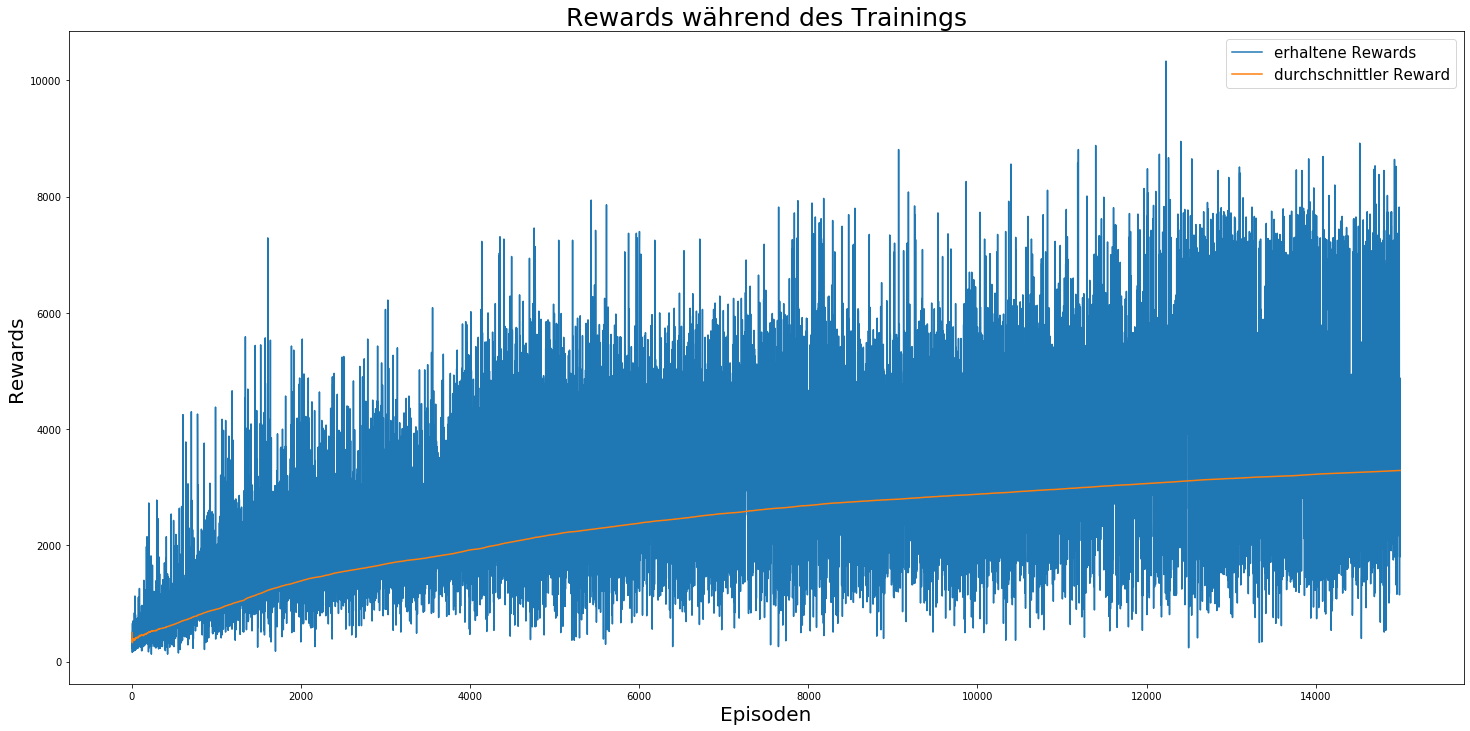

In [27]:
plt.figure(figsize=(25, 12))
plt.plot(REWARD_LIST, label="erhaltene Rewards")
plt.plot(MEAN_LIST, label="durchschnittler Reward")
plt.title("Rewards während des Trainings", fontsize=25)
plt.xlabel("Episoden", fontsize=20)
plt.ylabel("Rewards", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# **Trainierten Agenten spielen lassen**

In [ ]:
!ls "WEIGHTS/"

In [ ]:
# Gewichte laden
WEIGHTS_PATH = "WEIGHTS/Pong-v0_DQN_Ep_14840.h5"
DQN.load_weights(filepath=WEIGHTS_PATH)

## Rendering a Game

KeyboardInterrupt: 

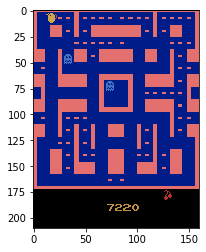

In [28]:
import gym
from IPython import display
import matplotlib
%matplotlib inline

for i in range(1):
    state = env.reset()
    done = False
    while not done:
        img = plt.imshow(env.render(mode='rgb_array'))
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = np.argmax(DQN.predict(state))
        state, reward, done, info = env.step(action)